# Setup

## Install Packages

In [1]:
# load those needed packages and libraries
import torch
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2.robjects as ro

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rpy2.robjects import pandas2ri

c:\Users\Bryan Chan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Device 

In [3]:
# set the device to cuda if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Datasets

## UNGA

In [7]:
data_dir = r'C:\Users\Bryan Chan\Documents\Projects\thesis_data\\'

# UN General Assembly
CB_UNGA = pd.read_csv(data_dir + r'UNGA\Speakers_by_session.csv')
CB_UNGA

,Year,Session,ISO Code,Country,Name of Person Speaking,Post,Unnamed: 6
0,2022,77,BRA,Brazil,Jair Bolsonaro,President,NaN
1,2022,77,SEN,Senegal,Macky Sail,President,NaN
2,2022,77,CHL,Chile,Gabriel Boric Font,President,NaN
3,2022,77,JOR,Jordan,Abdullah II ibn Al Hussein,King,NaN
4,2022,77,COL,Colombia,Gustavo Petro Urrego,President,NaN
...,...,...,...,...,...,...,...
10554,1946,1,USA,United States of America,Mr. Austin,NaN,NaN
10555,1946,1,IRN,Iran,Mr. Entezam,NaN,NaN
10556,1946,1,URY,Uruguay,Mr. Blanco,NaN,NaN
10557,1946,1,LUX,Luxembourg,Mr. Bech,NaN,NaN


## UNSC

In [8]:
r = ro.r 
r['load'](data_dir + r"UNSC\docs.RData")
r['load'](data_dir + r"UNSC\docs_meta.RData")

# Lists the objects currently in the R environment
loaded_objects = r['ls']()
print("Loaded objects:", loaded_objects)


Loaded objects: [1] "meta_meetings"           "meta_speeches"          
[3] "national_capacities"     "prst_speeches_filenames"
[5] "raw_docs"                "un_capacities"          



In [10]:
# Access the objects by their actual names
meta_meetings = r['meta_meetings']
meta_speeches = r['meta_speeches']
national_capacities = r['national_capacities']
prst_speeches_filenames = r['prst_speeches_filenames']
raw_docs = r['raw_docs']
un_capacities = r['un_capacities']

print("meta_meetings type:", type(meta_meetings))
print("meta_speeches type:", type(meta_speeches))
print("national_capacities type:", type(national_capacities))
print("prst_speeches_filenames type:", type(prst_speeches_filenames))
print("raw_docs type:", type(raw_docs))
print("un_capacities type:", type(un_capacities))

meta_meetings type: <class 'rpy2.robjects.vectors.DataFrame'>
meta_speeches type: <class 'rpy2.robjects.vectors.DataFrame'>
national_capacities type: <class 'numpy.ndarray'>
prst_speeches_filenames type: <class 'numpy.ndarray'>
raw_docs type: <class 'rpy2.robjects.vectors.DataFrame'>
un_capacities type: <class 'numpy.ndarray'>


In [11]:
pandas2ri.activate() # Activate the pandas conversion

# Convert R objects to pandas DataFrames
df_UNSC_meta_meetings = pandas2ri.rpy2py(meta_meetings)
df_UNSC_meta_speeches = pandas2ri.rpy2py(meta_speeches)
df_UNSC_national_capacities = pandas2ri.rpy2py(ro.r['as.data.frame'](national_capacities))
df_UNSC_prst_speeches_filenames = pandas2ri.rpy2py(ro.r['as.data.frame'](prst_speeches_filenames))
df_UNSC_raw_docs = pandas2ri.rpy2py(raw_docs)
df_UNSC_un_capacities = pandas2ri.rpy2py(ro.r['as.data.frame'](un_capacities))

# Save DataFrames to CSV files
df_UNSC_meta_meetings.to_csv(data_dir + r'df_UNSC_meta_meetings.csv', index=False)
df_UNSC_meta_speeches.to_csv(data_dir + r'df_UNSC_meta_speeches.csv', index=False)
df_UNSC_national_capacities.to_csv(data_dir + r'df_UNSC_national_capacities.csv', index=False)
df_UNSC_prst_speeches_filenames.to_csv(data_dir + r'df_UNSC_prst_speeches_filenames.csv', index=False)
df_UNSC_raw_docs.to_csv(data_dir + r'df_UNSC_raw_docs.csv', index=False)
df_UNSC_un_capacities.to_csv(data_dir + r'df_UNSC_un_capacities.csv', index=False)

In [ ]:
# Load DataFrames from CSV files
df_UNSC_meta_meetings = pd.read_csv(data_dir + r'df_UNSC_meta_meetings.csv')
df_UNSC_meta_speeches = pd.read_csv(data_dir + r'df_UNSC_meta_speeches.csv')
df_UNSC_national_capacities = pd.read_csv(data_dir + r'df_UNSC_national_capacities.csv')
df_UNSC_prst_speeches_filenames = pd.read_csv(data_dir + r'df_UNSC_prst_speeches_filenames.csv')
df_UNSC_raw_docs = pd.read_csv(data_dir + r'df_UNSC_raw_docs.csv')
df_UNSC_un_capacities = pd.read_csv(data_dir + r'df_UNSC_un_capacities.csv')


In [10]:
df_UNSC_meta_meetings


,basename,date,num_speeches,topic,pressrelease,outcome,year,month,day
1,UNSC_1995_SPV.3486,6 January 1995,1.0,Bosnia and Herzegovina,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995.0,01,06
2,UNSC_1995_SPV.3487,12 January 1995,40.0,Federal Republic of Yugoslavia (Serbia and Mon...,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995.0,01,12
3,UNSC_1995_SPV.3488,12 January 1995,12.0,Georgia,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995.0,01,12
4,UNSC_1995_SPV.3489,13 January 1995,16.0,Liberia,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995.0,01,13
5,UNSC_1995_SPV.3490,13 January 1995,1.0,Western Sahara,None,http://www.un.org/en/ga/search/view_doc.asp?sy...,1995.0,01,13
...,...,...,...,...,...,...,...,...,...
5586,UNSC_2020_SPV.8774,12 November 2020,4.0,Reports of the Secretary-General on the Sudan ...,https://www.un.org/press/en/2020/sc14354.doc.htm,http://undocs.org/en/S/RES/2550(2020),2020.0,11,12
5587,UNSC_2020_SPV.8775,12 November 2020,8.0,The situation in Somalia,https://www.un.org/press/en/2020/sc14355.doc.htm,http://undocs.org/en/S/RES/2551(2020),2020.0,11,12
5588,UNSC_2020_SPV.8776,12 November 2020,4.0,The situation in the Central African Republic,https://www.un.org/press/en/2020/sc14356.doc.htm,http://undocs.org/en/S/RES/2552(2020),2020.0,11,12
5589,UNSC_2020_SPV.8777,17 November 2020,3.0,The situation in Mali,http://www.un.org/press/en/2020/sc14359.doc.htm,None,2020.0,11,17


In [86]:
df_UNSC_meta_speeches

,speech,country,speaker,participanttype,role_in_un,spv,basename,topic,date,year,...,filename,types,tokens,sentences,topic2,subtopic,agenda_item1,agenda_item2,agenda_item3,decision
1,1.0,Argentina,Mr. Cardenas,The President,,3486,UNSC_1995_SPV.3486,Bosnia and Herzegovina,6 January 1995,1995.0,...,UNSC_1995_SPV.3486_spch001.txt,305.0,862.0,29.0,Items relating to the situation in the former ...,Bosnia and Herzegovina,Europe,Former Yugoslavia,Bosnia and Herzegovina,PRST
2,1.0,Argentina,Mr. Cardenas,The President,,3487,UNSC_1995_SPV.3487,Federal Republic of Yugoslavia (Serbia and Mon...,12 January 1995,1995.0,...,UNSC_1995_SPV.3487_spch001.txt,203.0,572.0,17.0,Items relating to the situation in the former ...,Bosnia and Herzegovina,Europe,Former Yugoslavia,Bosnia and Herzegovina,None
3,2.0,Bosnia And Herzegovina,Mr. Sacirbey,Guest,,3487,UNSC_1995_SPV.3487,Federal Republic of Yugoslavia (Serbia and Mon...,12 January 1995,1995.0,...,UNSC_1995_SPV.3487_spch002.txt,575.0,1746.0,45.0,Items relating to the situation in the former ...,Bosnia and Herzegovina,Europe,Former Yugoslavia,Bosnia and Herzegovina,None
4,3.0,Argentina,Mr. Cardenas,The President,,3487,UNSC_1995_SPV.3487,Federal Republic of Yugoslavia (Serbia and Mon...,12 January 1995,1995.0,...,UNSC_1995_SPV.3487_spch003.txt,22.0,23.0,1.0,Items relating to the situation in the former ...,Bosnia and Herzegovina,Europe,Former Yugoslavia,Bosnia and Herzegovina,None
5,4.0,Croatia,Mr. Nobilo,Guest,,3487,UNSC_1995_SPV.3487,Federal Republic of Yugoslavia (Serbia and Mon...,12 January 1995,1995.0,...,UNSC_1995_SPV.3487_spch004.txt,357.0,977.0,32.0,Items relating to the situation in the former ...,Bosnia and Herzegovina,Europe,Former Yugoslavia,Bosnia and Herzegovina,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82161,16.0,Tunisia,None,Mentioned,,2020_1324,UNSC_2020_SPV.2020_1324,Non-proliferation,22 December 2020,2020.0,...,UNSC_2020_SPV.2020_1324_spch016.txt,299.0,694.0,15.0,Items relating to non-proliferation,Non-proliferation of weapons of mass destruction,Thematic,Non-proliferation,Thematic,None
82162,17.0,United Kingdom Of Great Britain And Northern I...,Barbara Woodward,Mentioned,,2020_1324,UNSC_2020_SPV.2020_1324,Non-proliferation,22 December 2020,2020.0,...,UNSC_2020_SPV.2020_1324_spch017.txt,398.0,913.0,35.0,Items relating to non-proliferation,Non-proliferation of weapons of mass destruction,Thematic,Non-proliferation,Thematic,None
82163,18.0,United States Of America,Richard Mills,Mentioned,,2020_1324,UNSC_2020_SPV.2020_1324,Non-proliferation,22 December 2020,2020.0,...,UNSC_2020_SPV.2020_1324_spch018.txt,354.0,770.0,24.0,Items relating to non-proliferation,Non-proliferation of weapons of mass destruction,Thematic,Non-proliferation,Thematic,None
82164,19.0,Viet Nam,Pham Hai Anh,Mentioned,,2020_1324,UNSC_2020_SPV.2020_1324,Non-proliferation,22 December 2020,2020.0,...,UNSC_2020_SPV.2020_1324_spch019.txt,338.0,807.0,27.0,Items relating to non-proliferation,Non-proliferation of weapons of mass destruction,Thematic,Non-proliferation,Thematic,None


# EDA

In [24]:
# Who spoke the most
speaker_counts = CB_UNGA['Country'].value_counts().head(150)

plt.figure(figsize = (20, 6))
plt.bar(speaker_counts.index, speaker_counts.values)
plt.xlabel("Country")
plt.ylabel("Count of Speakers")
plt.title("Number of Speakers by Country in UN General Assembly")
plt.xticks(rotation=90)
plt.show()

NameError: name 'CB_UNGA' is not defined

In [43]:
# Speakers by Session and Year
pivot_table = pd.pivot_table(CB_UNGA, values='Name of Person Speaking', index=['Year', 'Session'], aggfunc='count')
pivot_table


,,Name of Person Speaking
Year,Session,
1946,1,39
1947,2,39
1948,3,39
1949,4,35
1950,5,44
...,...,...
2018,73,196
2019,74,195
2020,75,193


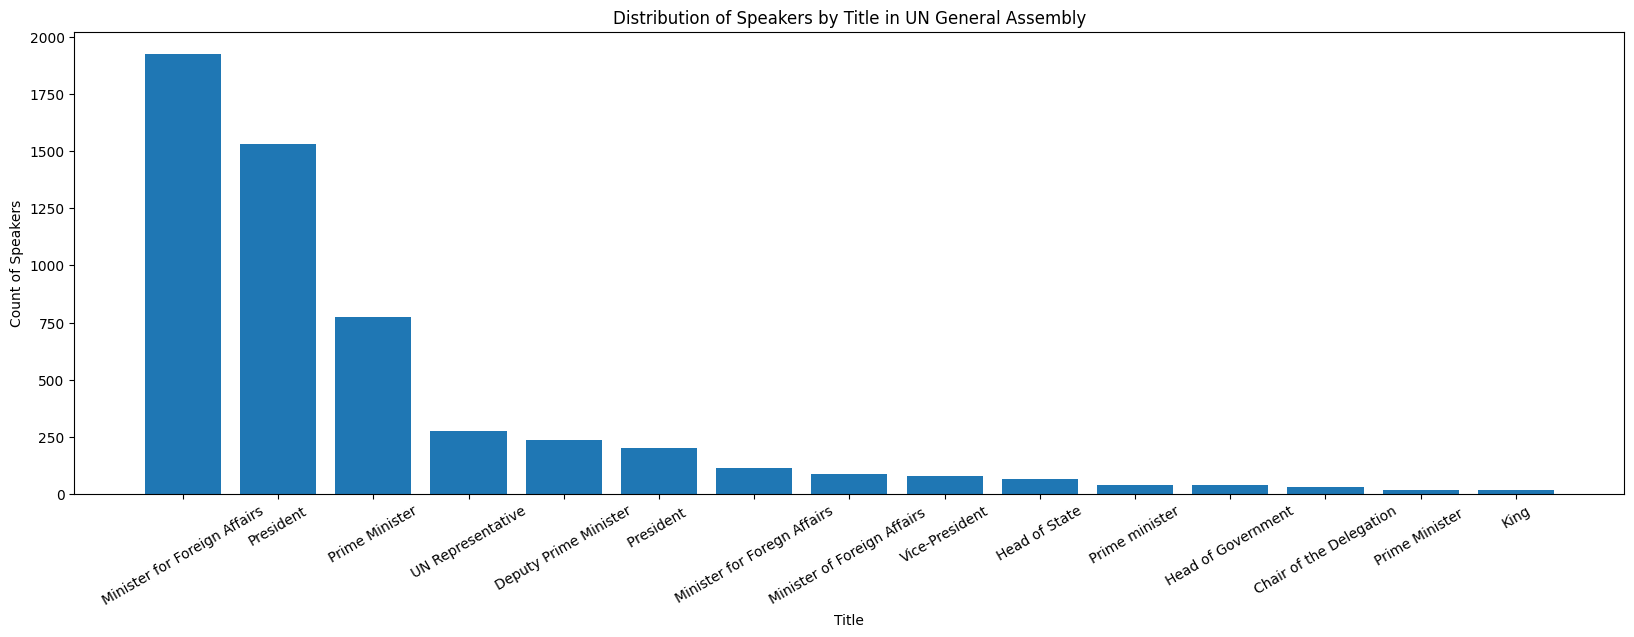

In [26]:
#Distribution of Speakers by Title
speaker_titles = CB_UNGA['Post'].value_counts().head(15)
plt.figure(figsize = (20, 6))
plt.bar(speaker_titles.index, speaker_titles.values)
plt.xlabel("Title")
plt.ylabel("Count of Speakers")
plt.title("Distribution of Speakers by Title in UN General Assembly")

plt.xticks(rotation=30)
plt.show()

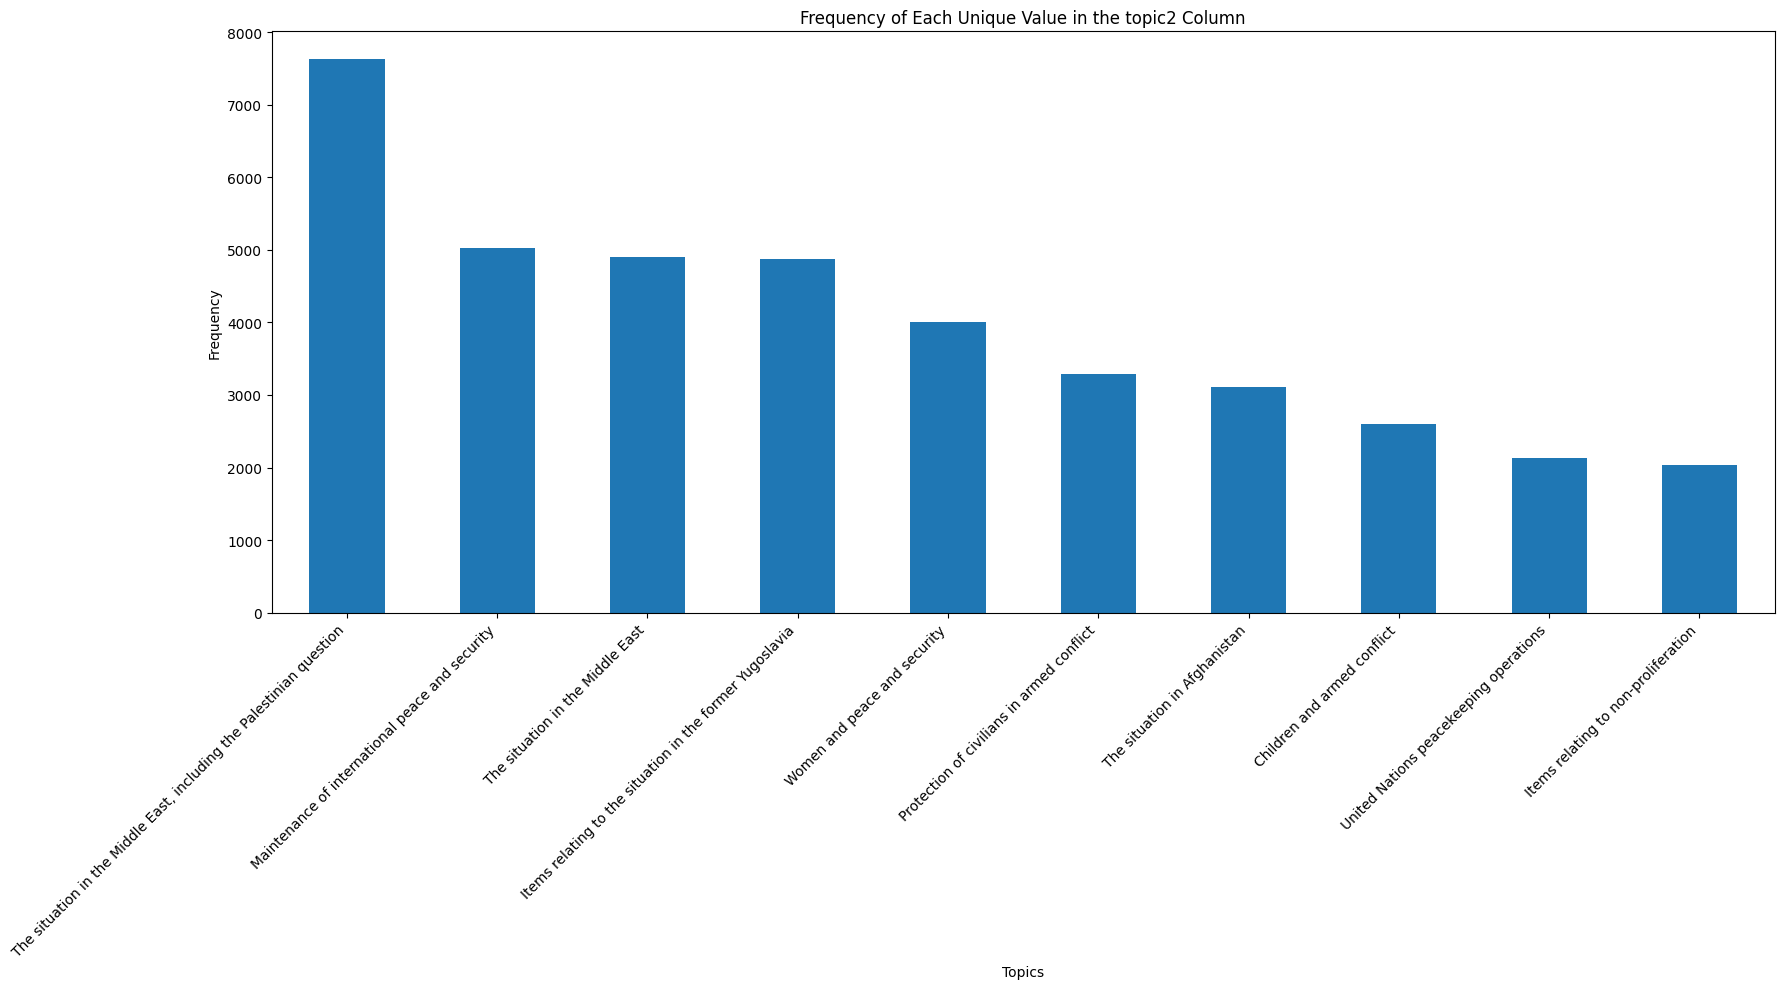

In [21]:
# Frequency of each unique value in the "topic2" column 

topic2_counts = df_UNSC_meta_speeches['topic2'].value_counts().head(10)
plt.figure(figsize=(18, 10))
topic2_counts.plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Frequency of Each Topic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

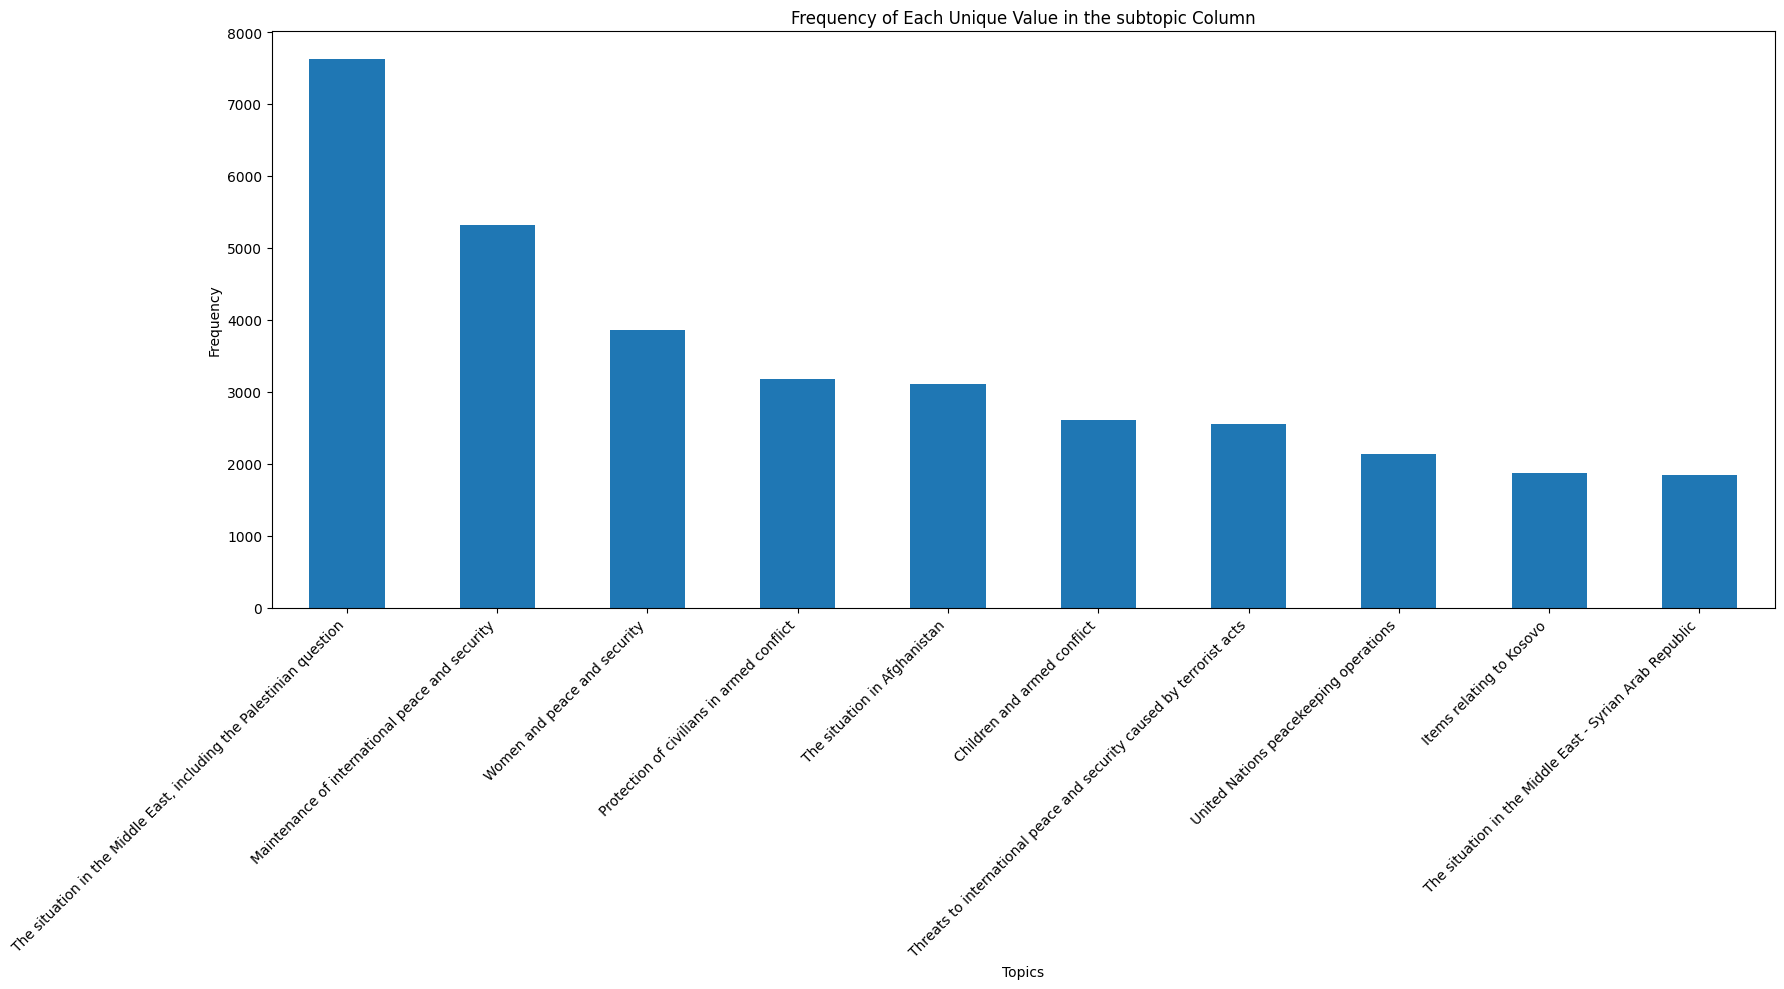

In [22]:
# Frequency of each unique value in the "subtopic" column 

topic2_counts = df_UNSC_meta_speeches['subtopic'].value_counts().head(10)
plt.figure(figsize=(18, 10))
topic2_counts.plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Frequency of Each Subtopic')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Fine-Tune Models

Models: T5 or BERT


## Training with T5

In [ ]:
# Load pre-trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Load dataset (this should include CoT examples)
dataset = load_dataset('path_to_your_dataset')

# Preprocess the dataset
def preprocess_data(examples):
    inputs = examples['input']
    cot_steps = examples['cot']  # Chain of Thought steps
    outputs = examples['output']

    model_inputs = tokenizer(inputs + cot_steps, max_length=512, 
                             truncation=True, 
                             padding='max_length', return_tensors="pt")
    labels = tokenizer(outputs, max_length=128, 
                       truncation=True, 
                       padding='max_length', return_tensors="pt")
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = dataset['train'].map(preprocess_data, batched=True)
val_dataset = dataset['validation'].map(preprocess_data, batched=True)

# Define training arguments
training_args = TrainingArguments(
    data_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=5e-5,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    load_best_model_at_end=True
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

## Training with BERT

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare your data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

# Assuming 'speeches' is a pandas DataFrame with your text data
speeches['text'] = speeches['filename'].apply(lambda x: open(x).read())
dataset = speeches['text']
dataset = dataset.map(tokenize, batched=True, batch_size=len(dataset))

# Define the training arguments
training_args = TrainingArguments(
    data_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Create the Trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()

# Counterfactual Sampling

In [ ]:
class Node:
    def __init__(self, state, parent=None):
        self.state = state
        self.parent = parent
        self.children = []
        self._number_of_visits = 0.
        self._results = 0.

    def expand(self):
        # Implement your expansion logic here
        pass

    def rollout(self):
        # Implement your rollout logic here
        pass

    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results += result
        if self.parent:
            self.parent.backpropagate(result)

    def is_fully_expanded(self):
        return len(self.children) > 0

    def best_child(self):
        # Implement your selection logic here
        pass

def MCTS(root, iterations):
    for _ in range(iterations):
        node = root
        while node.is_fully_expanded():
            node = node.best_child()
        if not node.is_terminal():
            node.expand()
        result = node.rollout()
        node.backpropagate(result)
    return root.best_child()
